In [40]:
import numpy as np
import pandas as pd

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.metrics import accuracy_score, classification_report
from scipy import stats
from tqdm.auto import tqdm


In [41]:
# Up to this point, keep what you have:
df = pd.read_csv("7282_1_dedupe_cleaned.csv")
df = df[df["reviews.rating"].notna() & df["reviews.text"].notna()]

df_sampled = (
    df.groupby("name")
      .head(20)                      # or sample per hotel if you want
      .reset_index(drop=True)
)

# For the next steps, just rename this so it matches the code I gave you:
sent_df = df_sampled.copy()


In [42]:
# --- 1) Map ratings to binary sentiment and filter out 3-star reviews
# Use `sent_df` (created earlier) rather than `df_sample`
df2 = sent_df.copy()
df2 = df2[['reviews.text', 'reviews.rating', 'province', 'city']].dropna()
df2['reviews.rating'] = pd.to_numeric(df2['reviews.rating'], errors='coerce')
df2 = df2.dropna(subset=['reviews.rating'])
# Keep only 1,2,4,5 and map 4-5 -> 1 (positive), 1-2 -> 0 (negative)
df2 = df2[df2['reviews.rating'] != 3]
df2['sentiment'] = df2['reviews.rating'].apply(lambda r: 1 if r >= 4 else 0)
print('Total reviews after filtering (no 3-star):', len(df2))
print(df2['sentiment'].value_counts())

Total reviews after filtering (no 3-star): 8460
sentiment
1    6522
0    1938
Name: count, dtype: int64


In [43]:
# --- 2) Balanced sampling across states to reduce location bias
# Parameters: adjust these based on your compute and data size
MIN_REVIEWS_PER_STATE = 500   # only include states with >= this many reviews
SAMPLE_PER_STATE = 1000      # target samples per eligible state (downsample to available)
state_counts = df2['province'].value_counts()
eligible_states = state_counts[state_counts >= MIN_REVIEWS_PER_STATE].index.tolist()
print('Number of eligible states:', len(eligible_states))
# Build balanced dataframe by downsampling each eligible state to SAMPLE_PER_STATE (or fewer if not available)
df_balanced_list = []
for st in eligible_states:
    sub = df2[df2['province'] == st]
    n = min(SAMPLE_PER_STATE, len(sub))
    df_balanced_list.append(sub.sample(n=n, random_state=42))
df_balanced = pd.concat(df_balanced_list).reset_index(drop=True)
print('Balanced dataset size:', len(df_balanced))
print(df_balanced['sentiment'].value_counts())

Number of eligible states: 1
Balanced dataset size: 694
sentiment
1    525
0    169
Name: count, dtype: int64


In [44]:
# --- 3) Stratified train/test split per state to preserve local ratios
from sklearn.model_selection import train_test_split
train_parts = []
test_parts = []
for st, group in df_balanced.groupby('province'):
    # Stratify by sentiment within each state
    tr, te = train_test_split(group, test_size=0.2, stratify=group['sentiment'], random_state=42)
    train_parts.append(tr)
    test_parts.append(te)
train_df = pd.concat(train_parts).reset_index(drop=True)
test_df = pd.concat(test_parts).reset_index(drop=True)
print('Train size:', len(train_df), 'Test size:', len(test_df))
print('Train sentiment distribution:')
print(train_df['sentiment'].value_counts(normalize=True))
print('Test sentiment distribution:')
print(test_df['sentiment'].value_counts(normalize=True))

Train size: 555 Test size: 139
Train sentiment distribution:
sentiment
1    0.756757
0    0.243243
Name: proportion, dtype: float64
Test sentiment distribution:
sentiment
1    0.755396
0    0.244604
Name: proportion, dtype: float64


In [45]:
# --- 4) Prepare Hugging Face Datasets, tokenize, and fine-tune a BERT binary classifier
# NOTE: Training on CPU may be slow. Reduce SAMPLE_PER_STATE or epochs if needed.
# Defensive checks: ensure train_df/test_df exist; if not, create from df_balanced
if 'train_df' not in globals() or 'test_df' not in globals():
    if 'df_balanced' in globals():
        from sklearn.model_selection import train_test_split
        train_parts = []
        test_parts = []
        for st, group in df_balanced.groupby('province'):
            # Stratify by sentiment within each state
            tr, te = train_test_split(group, test_size=0.2, stratify=group['sentiment'], random_state=42)
            train_parts.append(tr)
            test_parts.append(te)
        train_df = pd.concat(train_parts).reset_index(drop=True)
        test_df = pd.concat(test_parts).reset_index(drop=True)
        print('train_df/test_df created from df_balanced — Train size:', len(train_df), 'Test size:', len(test_df))
    else:
        raise RuntimeError('train_df/test_df not found and df_balanced is not defined. Run the earlier cells that produce df_balanced (balanced sampling) first.')

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import numpy as np
import transformers as _transformers
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Create HF datasets from pandas DataFrame (keep only necessary columns)
train_ds = Dataset.from_pandas(train_df[['reviews.text','sentiment']].rename(columns={'sentiment':'labels'}))
test_ds = Dataset.from_pandas(test_df[['reviews.text','sentiment']].rename(columns={'sentiment':'labels'}))
# Tokenize (batched)
def tokenize_batch(batch):
    return tokenizer(batch['reviews.text'], truncation=True, padding='max_length', max_length=256)
train_ds = train_ds.map(tokenize_batch, batched=True)
test_ds = test_ds.map(tokenize_batch, batched=True)
train_ds.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
test_ds.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
# Load model for binary classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
# Training arguments: choose compatible signature depending on transformers version
from distutils.version import LooseVersion
try:
    if LooseVersion(_transformers.__version__) >= LooseVersion('3.4.0'):
        training_args = TrainingArguments(
            output_dir='./bert_binary_out',
            num_train_epochs=2,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            evaluation_strategy='epoch',
            save_strategy='epoch',
            logging_steps=100,
            load_best_model_at_end=True,
            metric_for_best_model='eval_f1'
        )
    else:
        # Older transformers versions may not accept evaluation_strategy/save_strategy/load_best_model_at_end
        print(f"Detected transformers=={_transformers.__version__}; using fallback TrainingArguments without evaluation_strategy/load_best_model_at_end")
        training_args = TrainingArguments(
            output_dir='./bert_binary_out',
            num_train_epochs=2,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            logging_steps=100,
        )
except TypeError as e:
    # Fallback in case signature differs
    print('TrainingArguments signature error, falling back. Error:', e)
    training_args = TrainingArguments(
        output_dir='./bert_binary_out',
        num_train_epochs=2,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        logging_steps=100,
    )
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}
trainer = Trainer(model=model, args=training_args, train_dataset=train_ds, eval_dataset=test_ds, compute_metrics=compute_metrics)
# Start training (may be slow on CPU)
trainer.train()
eval_res = trainer.evaluate()
print('Evaluation results:', eval_res)

Map:   0%|          | 0/555 [00:00<?, ? examples/s]

Map:   0%|          | 0/139 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\vanoh\AppData\Local\Temp\ipykernel_5424\132694233.py:41: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\vanoh\AppData\Local\Temp\ipykernel_5424\132694233.py:41: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



TrainingArguments signature error, falling back. Error: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'


C:\Users\vanoh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



Step,Training Loss


C:\Users\vanoh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



Evaluation results: {'eval_loss': 0.2292826771736145, 'eval_accuracy': 0.9064748201438849, 'eval_precision': 0.9259259259259259, 'eval_recall': 0.9523809523809523, 'eval_f1': 0.9389671361502347, 'eval_runtime': 29.6063, 'eval_samples_per_second': 4.695, 'eval_steps_per_second': 0.169, 'epoch': 2.0}


In [46]:
# --- 5) Predictions, classification report, and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
pred_out = trainer.predict(test_ds)
y_pred = np.argmax(pred_out.predictions, axis=1)
y_true = pred_out.label_ids
print(classification_report(y_true, y_pred, target_names=['negative','positive']))
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:', cm)

C:\Users\vanoh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



              precision    recall  f1-score   support

    negative       0.84      0.76      0.80        34
    positive       0.93      0.95      0.94       105

    accuracy                           0.91       139
   macro avg       0.88      0.86      0.87       139
weighted avg       0.90      0.91      0.90       139

Confusion matrix: [[ 26   8]
 [  5 100]]


In [47]:
# --- 6) Statistical tests: chi-square and logistic regression (province -> sentiment)
import scipy.stats as stats
contingency = pd.crosstab(df_balanced['province'], df_balanced['sentiment'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f'Chi-square: {chi2:.3f}, p-value: {p:.6f}, dof: {dof}')
# Logistic regression with state dummies to assess state-level effects
import statsmodels.api as sm
X = pd.get_dummies(df_balanced['province'], drop_first=True)
y = df_balanced['sentiment']
X = sm.add_constant(X)
logit = sm.Logit(y, X).fit(disp=False)
print(logit.summary())

Chi-square: 0.000, p-value: 1.000000, dof: 0
                           Logit Regression Results                           
Dep. Variable:              sentiment   No. Observations:                  694
Model:                          Logit   Df Residuals:                      693
Method:                           MLE   Df Model:                            0
Date:                Sat, 06 Dec 2025   Pseudo R-squ.:               3.408e-14
Time:                        13:00:37   Log-Likelihood:                -385.24
converged:                       True   LL-Null:                       -385.24
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1335      0.088     12.816      0.000       0.960       1.307


**Next steps / notes:**
- The notebook now maps ratings to binary sentiment (4-5 -> positive, 1-2 -> negative) and filters out 3-star reviews.
- It builds a balanced dataset across eligible states, fine-tunes a BERT binary classifier, evaluates performance, runs a chi-square test and logistic regression, and creates the requested visualizations.
- Training on CPU can be slow — reduce `SAMPLE_PER_STATE` and `num_train_epochs` for quick runs, or switch `TrainingArguments` to use a GPU if available (set `device` accordingly).

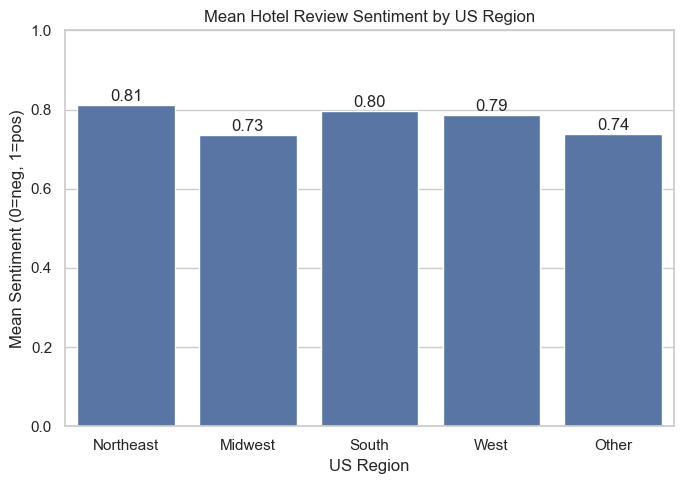

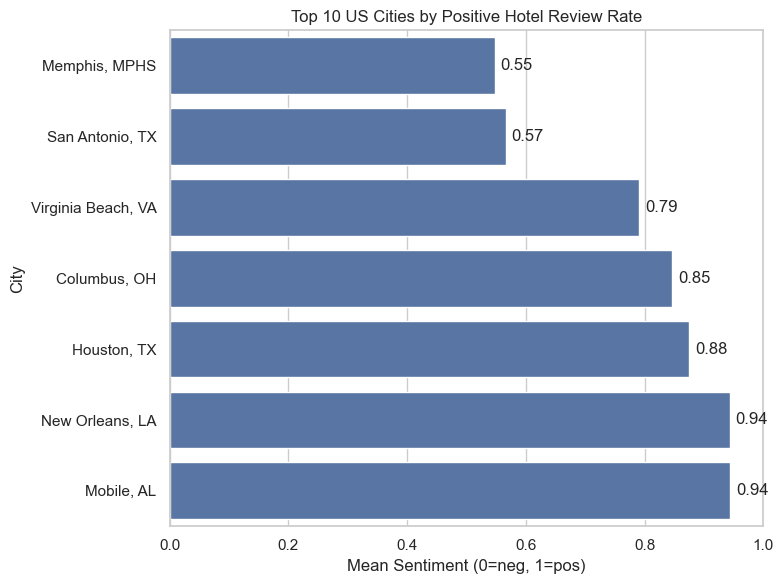

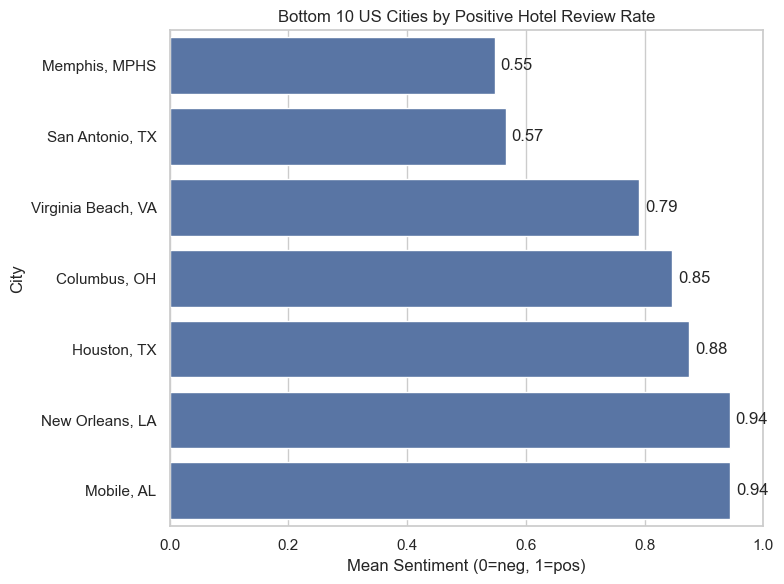

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ---- Use all reviews with binary sentiment (not df_balanced) ----
loc_df = df2.copy()

# Clean state codes
loc_df['province'] = loc_df['province'].astype(str).str.upper().str.strip()

# ---------- 1) Bar plot: mean sentiment (0–1) vs 5 US regions ----------

# Map 2-letter states to Census regions
region_map = {
    'ME':'Northeast','NH':'Northeast','VT':'Northeast','MA':'Northeast',
    'RI':'Northeast','CT':'Northeast','NY':'Northeast','NJ':'Northeast',
    'PA':'Northeast',
    'OH':'Midwest','IN':'Midwest','IL':'Midwest','MI':'Midwest','WI':'Midwest',
    'MN':'Midwest','IA':'Midwest','MO':'Midwest','ND':'Midwest','SD':'Midwest',
    'NE':'Midwest','KS':'Midwest',
    'DE':'South','MD':'South','DC':'South','VA':'South','WV':'South',
    'NC':'South','SC':'South','GA':'South','FL':'South',
    'KY':'South','TN':'South','MS':'South','AL':'South',
    'OK':'South','TX':'South','AR':'South','LA':'South',
    'MT':'West','ID':'West','WY':'West','CO':'West','NM':'West','AZ':'West',
    'UT':'West','NV':'West','WA':'West','OR':'West','CA':'West','AK':'West','HI':'West'
}

loc_df['region'] = loc_df['province'].map(region_map).fillna('Other')

# Mean positive rate (sentiment==1) per region
region_rates = (loc_df
                .groupby('region')['sentiment']
                .mean()
                .reindex(['Northeast','Midwest','South','West','Other'])
                .dropna()
               )

plt.figure(figsize=(7,5))
sns.barplot(x=region_rates.index, y=region_rates.values)
plt.ylim(0,1)
plt.ylabel('Mean Sentiment (0=neg, 1=pos)')
plt.xlabel('US Region')
plt.title('Mean Hotel Review Sentiment by US Region')
for i, v in enumerate(region_rates.values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# ---------- 2) Top 10 US cities with BEST reviews ----------

# Make sure 'city' exists
loc_df['city'] = loc_df['city'].astype(str).str.strip()

# Aggregate: mean sentiment + review count per (city, state)
city_stats = (loc_df
              .groupby(['city','province'])['sentiment']
              .agg(['mean','count'])
              .rename(columns={'mean':'positive_rate','count':'n_reviews'})
             )

MIN_REVIEWS_PER_CITY = 50   # adjust if needed

# Filter to cities with enough reviews and reset index so city/province are columns
eligible_cities = (city_stats[city_stats['n_reviews'] >= MIN_REVIEWS_PER_CITY]
                   .reset_index())

# Create pretty label "City, ST"
eligible_cities['label'] = (
    eligible_cities['city'].astype(str) + ', ' + eligible_cities['province'].astype(str)
)

# Top 10 best
top10 = (eligible_cities
         .sort_values('positive_rate', ascending=False)
         .head(10)
         .sort_values('positive_rate', ascending=True))   # sort for nicer plotting order

plt.figure(figsize=(8,6))
sns.barplot(x='positive_rate', y='label', data=top10)
plt.xlim(0,1)
plt.xlabel('Mean Sentiment (0=neg, 1=pos)')
plt.ylabel('City')
plt.title('Top 10 US Cities by Positive Hotel Review Rate')
for i, v in enumerate(top10['positive_rate']):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center')
plt.tight_layout()
plt.show()

# ---------- 3) Top 10 US cities with WORST reviews ----------

bottom10 = (eligible_cities
            .sort_values('positive_rate', ascending=True)
            .head(10)
            .sort_values('positive_rate', ascending=True))

plt.figure(figsize=(8,6))
sns.barplot(x='positive_rate', y='label', data=bottom10)
plt.xlim(0,1)
plt.xlabel('Mean Sentiment (0=neg, 1=pos)')
plt.ylabel('City')
plt.title('Bottom 10 US Cities by Positive Hotel Review Rate')
for i, v in enumerate(bottom10['positive_rate']):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center')
plt.tight_layout()
plt.show()


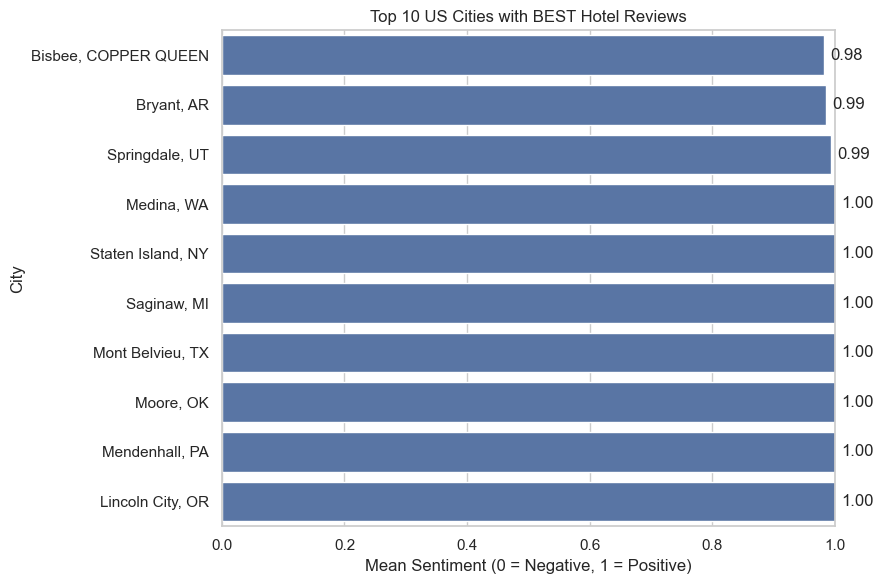

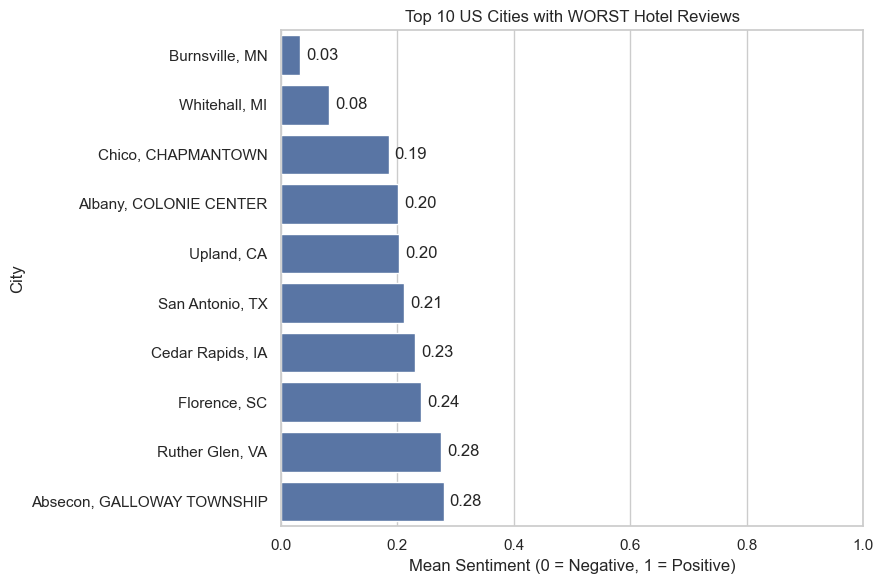

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

# -------------------------------
# 1) Build clean city sentiment dataframe from ORIGINAL df
# -------------------------------
city_df = df[['reviews.rating', 'province', 'city']].copy()

city_df = city_df.dropna(subset=['reviews.rating', 'province', 'city'])
city_df['reviews.rating'] = pd.to_numeric(city_df['reviews.rating'], errors='coerce')
city_df = city_df.dropna(subset=['reviews.rating'])

# Remove neutral 3-star reviews
city_df = city_df[city_df['reviews.rating'] != 3]

# Binary sentiment
city_df['sentiment'] = city_df['reviews.rating'].apply(lambda r: 1 if r >= 4 else 0)

# Clean strings
city_df['province'] = city_df['province'].astype(str).str.upper().str.strip()
city_df['city'] = city_df['city'].astype(str).str.strip()

# -------------------------------
# 2) Aggregate sentiment by city
# -------------------------------
city_stats = (
    city_df
    .groupby(['city', 'province'])['sentiment']
    .agg(['mean', 'count'])
    .rename(columns={'mean':'positive_rate', 'count':'n_reviews'})
    .reset_index()
)

# Only keep cities with enough reviews to be meaningful
MIN_REVIEWS_PER_CITY = 50
eligible_cities = city_stats[city_stats['n_reviews'] >= MIN_REVIEWS_PER_CITY].copy()

eligible_cities['label'] = (
    eligible_cities['city'] + ', ' + eligible_cities['province']
)

# -------------------------------
# ✅ PLOT 1: TOP 10 BEST CITIES
# -------------------------------
top10 = (eligible_cities
         .sort_values('positive_rate', ascending=False)
         .head(10)
         .sort_values('positive_rate', ascending=True))

plt.figure(figsize=(9,6))
sns.barplot(x='positive_rate', y='label', data=top10)
plt.xlim(0,1)
plt.xlabel('Mean Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('City')
plt.title('Top 10 US Cities with BEST Hotel Reviews')

for i, v in enumerate(top10['positive_rate']):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center')

plt.tight_layout()
plt.show()

# -------------------------------
# ✅ PLOT 2: TOP 10 WORST CITIES
# -------------------------------
bottom10 = (eligible_cities
            .sort_values('positive_rate', ascending=True)
            .head(10)
            .sort_values('positive_rate', ascending=True))

plt.figure(figsize=(9,6))
sns.barplot(x='positive_rate', y='label', data=bottom10)
plt.xlim(0,1)
plt.xlabel('Mean Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('City')
plt.title('Top 10 US Cities with WORST Hotel Reviews')

for i, v in enumerate(bottom10['positive_rate']):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center')

plt.tight_layout()
plt.show()
